In [2]:
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.4.2 imbalanced-learn==0.11.0

Found existing installation: scikit-learn 1.5.1
Uninstalling scikit-learn-1.5.1:
  Successfully uninstalled scikit-learn-1.5.1
Found existing installation: imbalanced-learn 0.12.2
Uninstalling imbalanced-learn-0.12.2:
  Successfully uninstalled imbalanced-learn-0.12.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 61.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imbalanced-learn]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
cuml-cu12 25.6.0 requires scikit-learn>=1.5, but you have scikit-learn 1.4.2 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.


In [1]:
import sklearn, imblearn, numpy, scipy
print("numpy:", numpy.__version__)
print("scipy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)
print("imblearn:", imblearn.__version__)

numpy: 1.26.4
scipy: 1.13.1
scikit-learn: 1.4.2
imblearn: 0.11.0


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uom190346a/global-coffee-health-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'global-coffee-health-dataset' dataset.
Path to dataset files: /kaggle/input/global-coffee-health-dataset


In [96]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import trange
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings("ignore")
sns.set()

In [4]:
os.listdir("/kaggle/input/global-coffee-health-dataset")

['synthetic_coffee_health_10000.csv']

In [5]:
df = pd.read_csv("/kaggle/input/global-coffee-health-dataset/synthetic_coffee_health_10000.csv")
df.head()

,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [6]:
df.shape

(10000, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   Country                  10000 non-null  object 
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  object 
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Stress_Level             10000 non-null  object 
 11  Physical_Activity_Hours  10000 non-null  float64
 12  Health_Issues            4059 non-null   object 
 13  Occupation               10000 non-null  object 
 14  Smoking                

In [8]:
df.apply(pd.isnull).sum()

,0
ID,0
Age,0
Gender,0
Country,0
Coffee_Intake,0
Caffeine_mg,0
Sleep_Hours,0
Sleep_Quality,0
BMI,0
Heart_Rate,0


In [9]:
df.duplicated().sum()

0

In [10]:
df.describe()

,ID,Age,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Physical_Activity_Hours,Smoking,Alcohol_Consumption
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000
mean,5000.50000,34.949100,2.509230,238.411010,6.636220,23.986860,70.617800,7.48704,0.20040,0.300700
std,2886.89568,11.160939,1.450248,137.748815,1.222055,3.906411,9.822951,4.31518,0.40032,0.458585
min,1.00000,18.000000,0.000000,0.000000,3.000000,15.000000,50.000000,0.00000,0.00000,0.000000
25%,2500.75000,26.000000,1.500000,138.750000,5.800000,21.300000,64.000000,3.70000,0.00000,0.000000
50%,5000.50000,34.000000,2.500000,235.400000,6.600000,24.000000,71.000000,7.50000,0.00000,0.000000
75%,7500.25000,43.000000,3.500000,332.025000,7.500000,26.600000,77.000000,11.20000,0.00000,1.000000
max,10000.00000,80.000000,8.200000,780.300000,10.000000,38.200000,109.000000,15.00000,1.00000,1.000000


In [11]:
df["Sleep_Quality"].value_counts()

,count
Sleep_Quality,
Good,5637
Fair,2050
Excellent,1352
Poor,961


In [12]:
df.drop(columns = ["ID", "Health_Issues"], axis = 1, inplace = True)

In [13]:
df.head()

,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Occupation,Smoking,Alcohol_Consumption
0,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,Other,0,0
1,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,Service,0,0
2,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Office,0,0
3,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Other,0,0
4,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Student,0,1


In [14]:
cat_cols, num_cols = [], []
for column in df.columns:
    if df[column].dtype == "object" or df[column].nunique() <= 10:
        cat_cols.append(column)
    else:
        num_cols.append(column)

In [15]:
print(f"Categorical columns: {cat_cols}")
print(f"Number of categorical columns: {len(cat_cols)}")
print("\n")
print(f"Numerical columns: {num_cols}")
print(f"Number of numerical columns: {len(num_cols)}")

Categorical columns: ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 'Occupation', 'Smoking', 'Alcohol_Consumption']
Number of categorical columns: 7


Numerical columns: ['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours']
Number of numerical columns: 7


Column name: Gender
Number of unique values: 3
Unique values: ['Male' 'Female' 'Other']
Value counts of unique values: Gender
Female    5001
Male      4773
Other      226
Name: count, dtype: int64


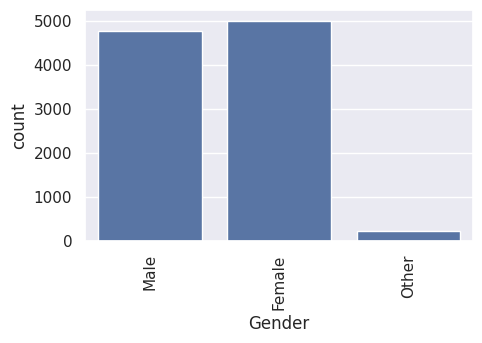

********************************************************************************
Column name: Country
Number of unique values: 20
Unique values: ['Germany' 'Brazil' 'Spain' 'Mexico' 'France' 'Canada' 'UK' 'Switzerland'
 'Netherlands' 'Italy' 'China' 'Japan' 'Belgium' 'Finland' 'Australia'
 'USA' 'Sweden' 'India' 'Norway' 'South Korea']
Value counts of unique values: Country
Canada         543
India          524
Norway         523
China          521
UK             519
Sweden         513
South Korea    512
Finland        510
Italy          509
Switzerland    500
France         499
Belgium        497
Australia      497
Germany        497
Netherlands    494
Spain          486
Mexico         483
Japan          469
Brazil         456
USA            448
Name: count, dtype: int64


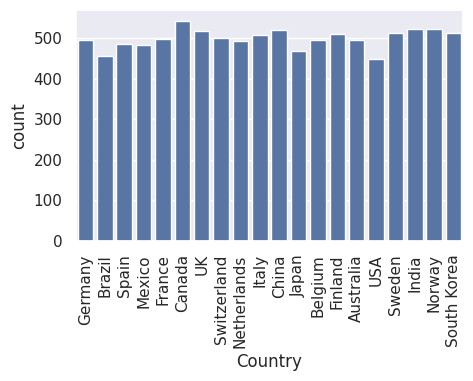

********************************************************************************
Column name: Sleep_Quality
Number of unique values: 4
Unique values: ['Good' 'Fair' 'Excellent' 'Poor']
Value counts of unique values: Sleep_Quality
Good         5637
Fair         2050
Excellent    1352
Poor          961
Name: count, dtype: int64


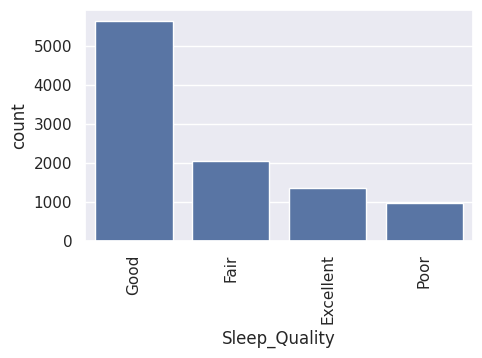

********************************************************************************
Column name: Stress_Level
Number of unique values: 3
Unique values: ['Low' 'Medium' 'High']
Value counts of unique values: Stress_Level
Low       6989
Medium    2050
High       961
Name: count, dtype: int64


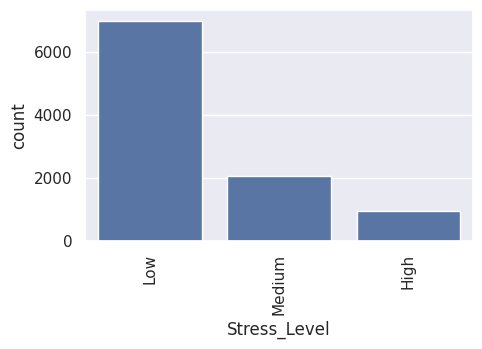

********************************************************************************
Column name: Occupation
Number of unique values: 5
Unique values: ['Other' 'Service' 'Office' 'Student' 'Healthcare']
Value counts of unique values: Occupation
Office        2073
Other         2038
Student       1968
Healthcare    1964
Service       1957
Name: count, dtype: int64


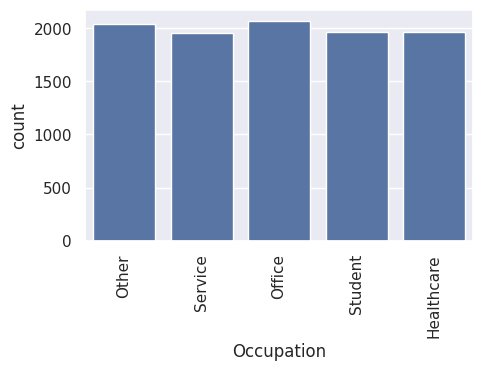

********************************************************************************
Column name: Smoking
Number of unique values: 2
Unique values: [0 1]
Value counts of unique values: Smoking
0    7996
1    2004
Name: count, dtype: int64


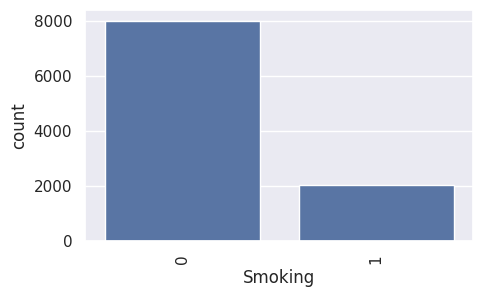

********************************************************************************
Column name: Alcohol_Consumption
Number of unique values: 2
Unique values: [0 1]
Value counts of unique values: Alcohol_Consumption
0    6993
1    3007
Name: count, dtype: int64


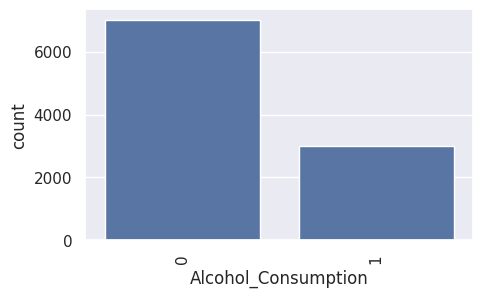

********************************************************************************


In [16]:
for column in cat_cols:
    print(f"Column name: {column}")
    print(f"Number of unique values: {df[column].nunique()}")
    print(f"Unique values: {df[column].unique()}")
    print(f"Value counts of unique values: {df[column].value_counts()}")
    plt.figure(figsize = (5, 3))
    sns.countplot(data = df, x = column)
    plt.xticks(rotation = 90)
    plt.show()
    print("*" * 80)

In [17]:
df = df[df["Gender"] != "Other"]

In [18]:
df.shape

(9774, 14)

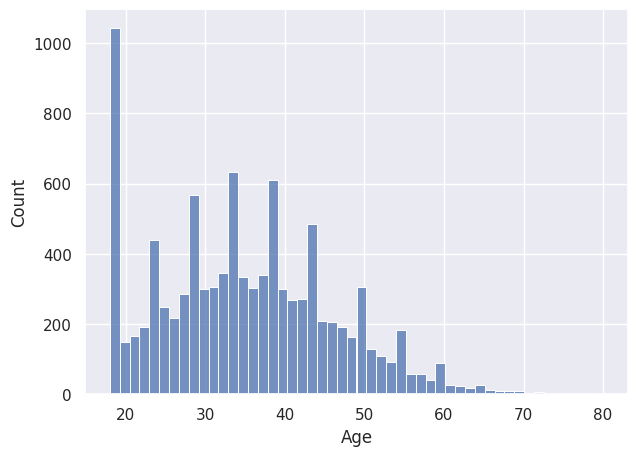

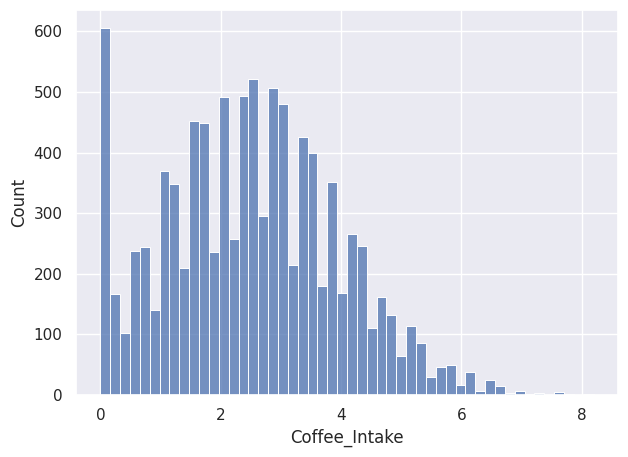

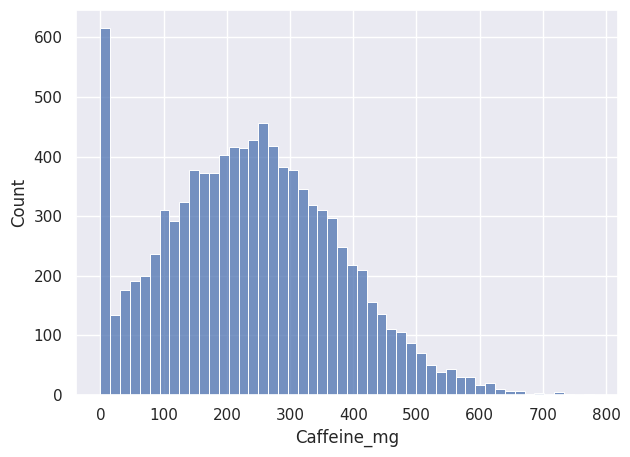

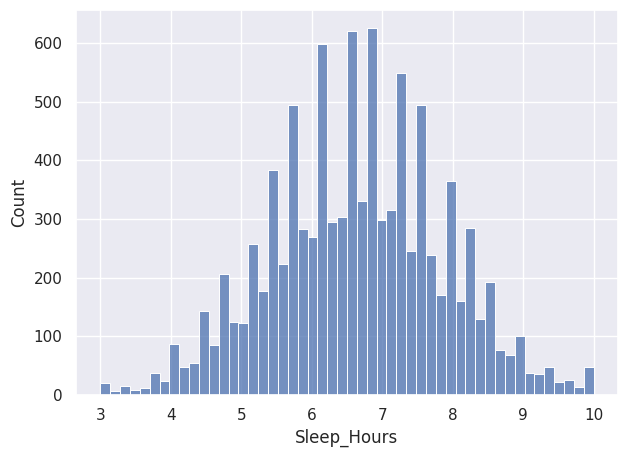

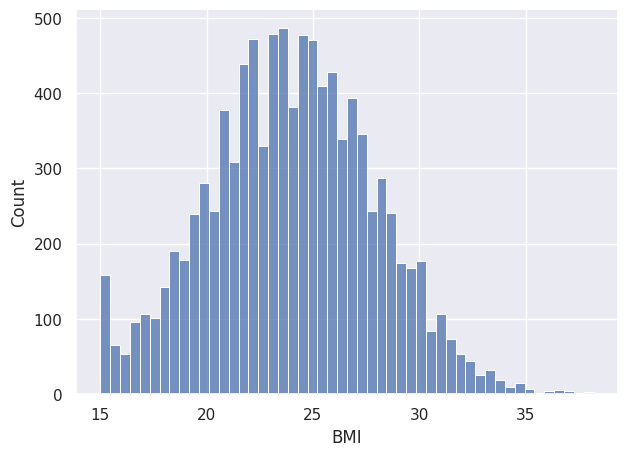

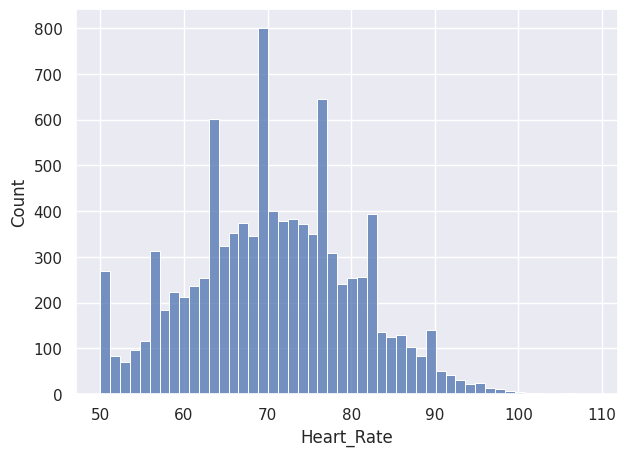

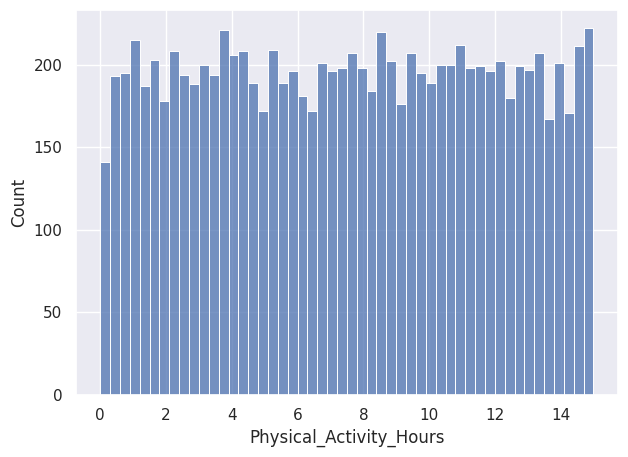

In [19]:
for column in num_cols:
    plt.figure(figsize = (7, 5))
    sns.histplot(data = df, x = column, bins = 50)
    plt.show()

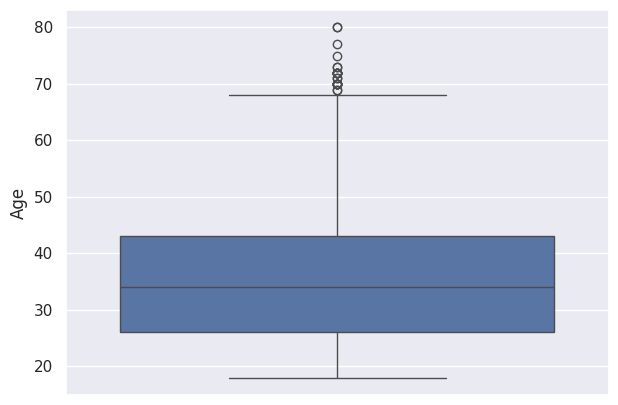

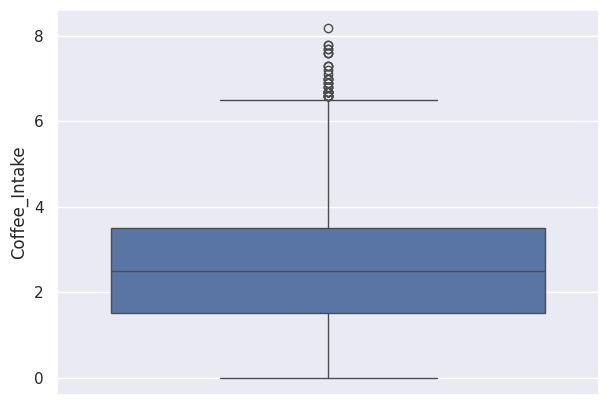

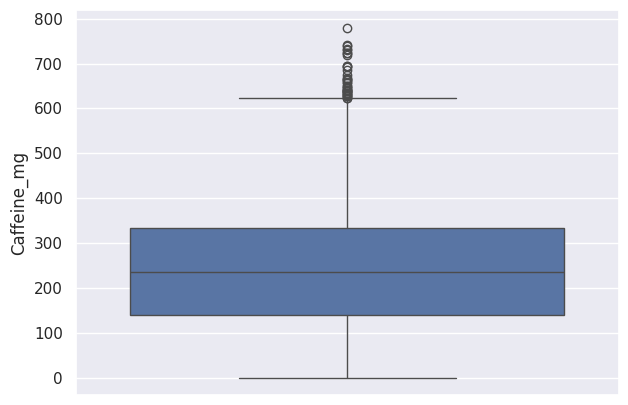

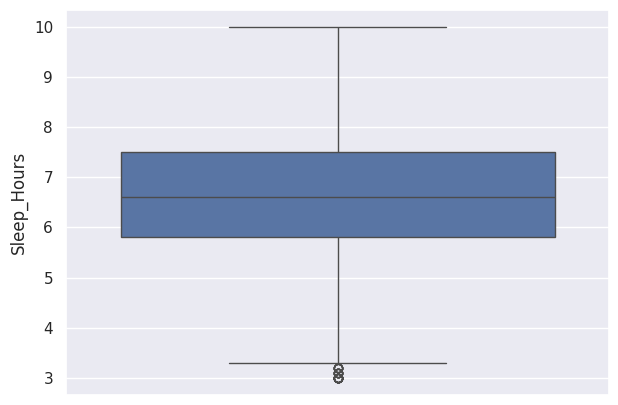

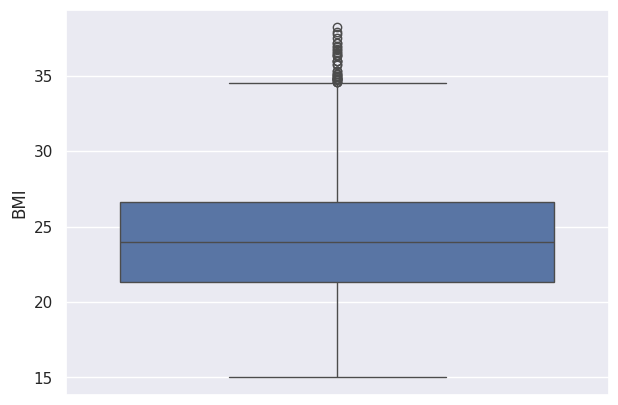

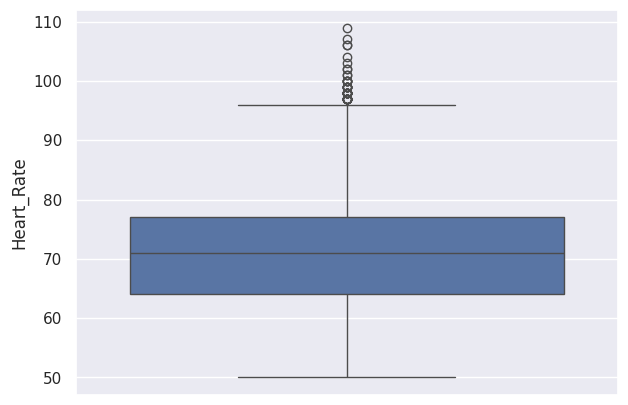

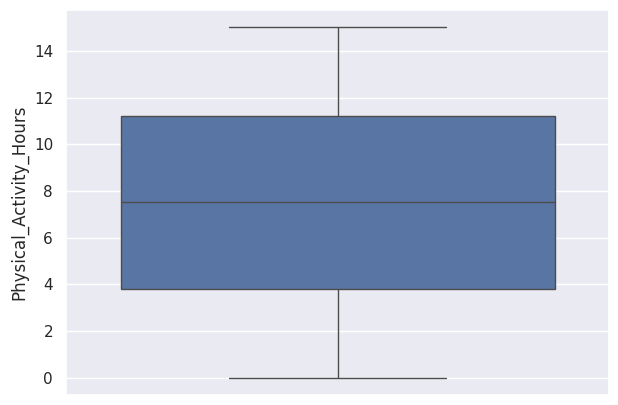

In [20]:
for column in num_cols:
    plt.figure(figsize = (7, 5))
    sns.boxplot(data = df, y = column)
    plt.show()

In [21]:
df[df["Age"] > 67].shape

(33, 14)

In [22]:
df = df[df["Age"] < 68]

In [23]:
df[df["Coffee_Intake"] > 6.30].shape

(63, 14)

In [24]:
df = df[df["Coffee_Intake"] <= 6.30]

In [25]:
df[df["Caffeine_mg"] > 610].shape

(0, 14)

In [26]:
df[df["Sleep_Hours"] < 3.10].shape

(14, 14)

In [27]:
df = df[df["Sleep_Hours"] >= 3.10]

In [28]:
df[df["BMI"] > 33].shape

(99, 14)

In [29]:
df = df[df["BMI"] < 34]

In [30]:
df[df["Heart_Rate"] > 95].shape

(53, 14)

In [31]:
df = df[df["Heart_Rate"] < 96]

In [32]:
df.shape

(9556, 14)

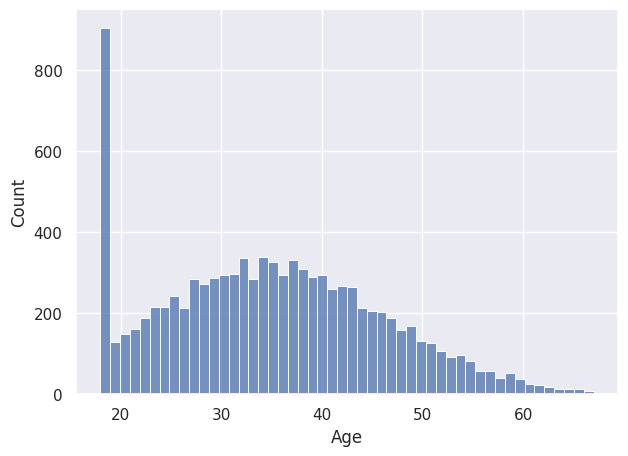

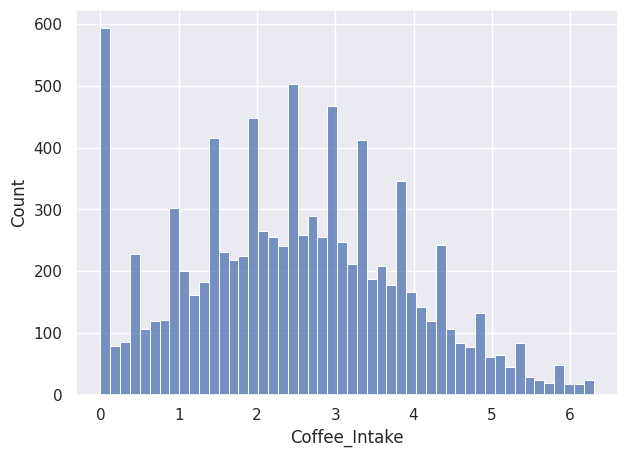

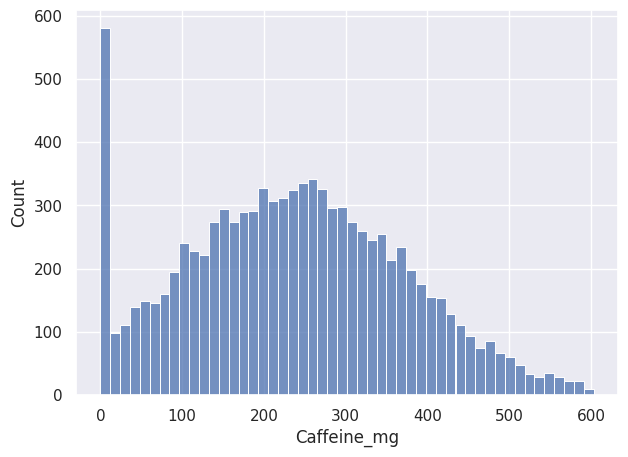

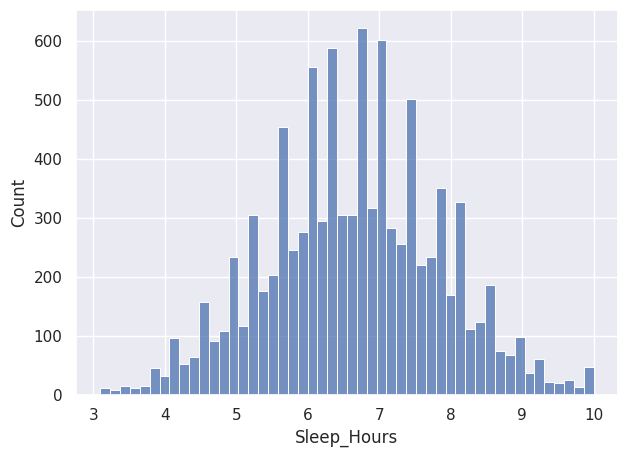

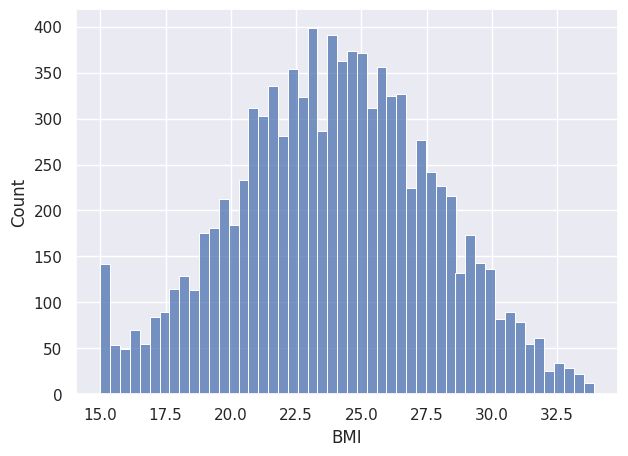

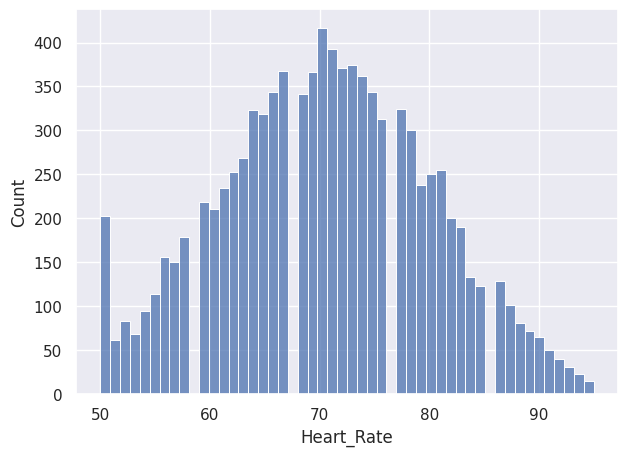

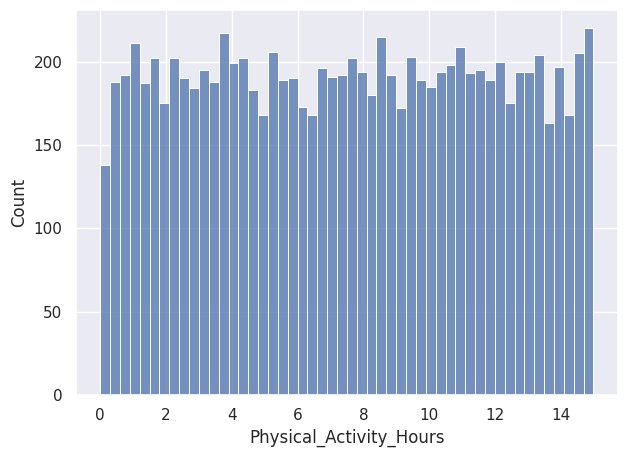

In [33]:
for column in num_cols:
    plt.figure(figsize = (7, 5))
    sns.histplot(data = df, x = column, bins = 50)
    plt.show()

In [34]:
df[df["Age"] > 60].shape

(111, 14)

In [35]:
df = df[df["Age"] <= 60]

In [36]:
df.shape

(9445, 14)

In [37]:
df["Sleep_Quality"].value_counts()

,count
Sleep_Quality,
Good,5336
Fair,1941
Excellent,1288
Poor,880


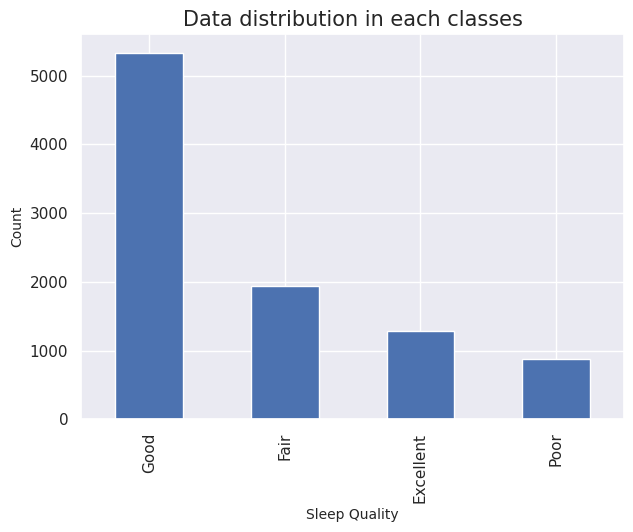

In [38]:
df["Sleep_Quality"].value_counts().plot(kind = "bar", figsize = (7, 5))
plt.title("Data distribution in each classes", fontsize = 15)
plt.xlabel("Sleep Quality", fontsize = 10)
plt.ylabel("Count", fontsize = 10)
plt.show()

Column name: Gender
Number of unique values: 2
Unique values: ['Male' 'Female']
Value counts of unique values: Gender
Female    4826
Male      4619
Name: count, dtype: int64


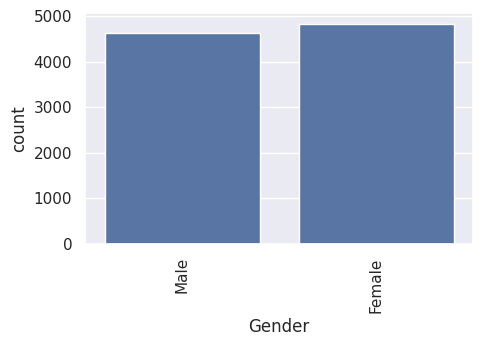

********************************************************************************
Column name: Country
Number of unique values: 20
Unique values: ['Germany' 'Brazil' 'Spain' 'Mexico' 'France' 'Canada' 'UK' 'Switzerland'
 'Netherlands' 'Italy' 'China' 'Japan' 'Belgium' 'Finland' 'Australia'
 'USA' 'Sweden' 'India' 'Norway' 'South Korea']
Value counts of unique values: Country
Canada         515
India          496
Norway         492
UK             490
China          489
Italy          489
Finland        487
Sweden         486
South Korea    480
Belgium        476
Germany        474
Switzerland    471
Australia      471
France         468
Netherlands    462
Spain          458
Mexico         454
Japan          442
USA            423
Brazil         422
Name: count, dtype: int64


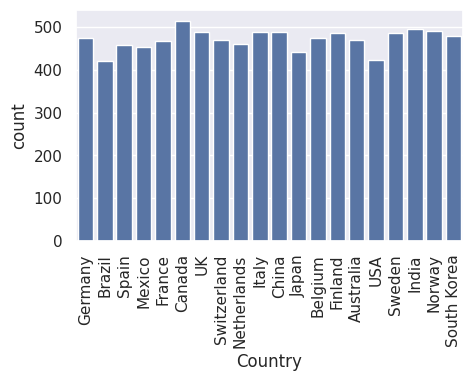

********************************************************************************
Column name: Sleep_Quality
Number of unique values: 4
Unique values: ['Good' 'Fair' 'Excellent' 'Poor']
Value counts of unique values: Sleep_Quality
Good         5336
Fair         1941
Excellent    1288
Poor          880
Name: count, dtype: int64


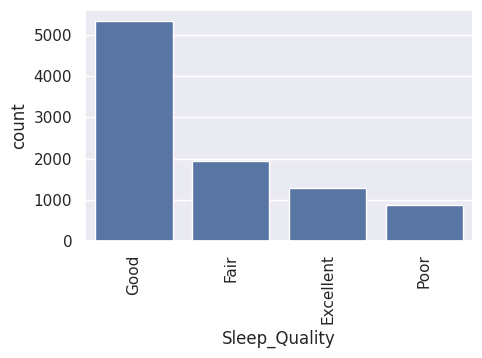

********************************************************************************
Column name: Stress_Level
Number of unique values: 3
Unique values: ['Low' 'Medium' 'High']
Value counts of unique values: Stress_Level
Low       6624
Medium    1941
High       880
Name: count, dtype: int64


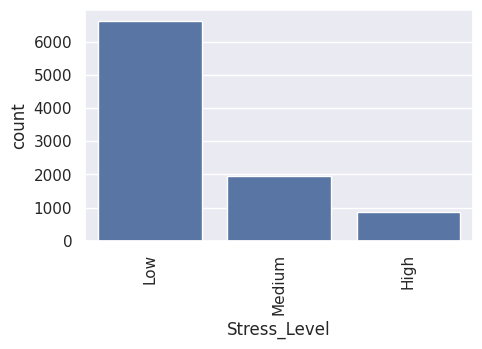

********************************************************************************
Column name: Occupation
Number of unique values: 5
Unique values: ['Other' 'Service' 'Office' 'Student' 'Healthcare']
Value counts of unique values: Occupation
Office        1964
Other         1918
Student       1858
Healthcare    1853
Service       1852
Name: count, dtype: int64


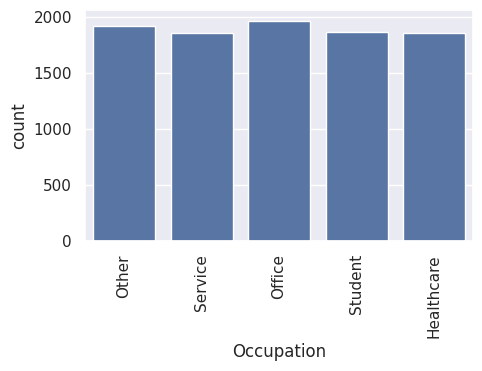

********************************************************************************
Column name: Smoking
Number of unique values: 2
Unique values: [0 1]
Value counts of unique values: Smoking
0    7561
1    1884
Name: count, dtype: int64


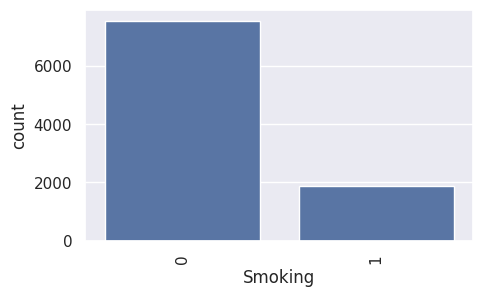

********************************************************************************
Column name: Alcohol_Consumption
Number of unique values: 2
Unique values: [0 1]
Value counts of unique values: Alcohol_Consumption
0    6611
1    2834
Name: count, dtype: int64


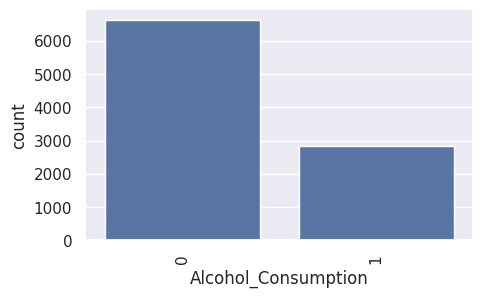

********************************************************************************


In [39]:
for column in cat_cols:
    print(f"Column name: {column}")
    print(f"Number of unique values: {df[column].nunique()}")
    print(f"Unique values: {df[column].unique()}")
    print(f"Value counts of unique values: {df[column].value_counts()}")
    plt.figure(figsize = (5, 3))
    sns.countplot(data = df, x = column)
    plt.xticks(rotation = 90)
    plt.show()
    print("*" * 80)

In [40]:
df.describe()

,Age,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Physical_Activity_Hours,Smoking,Alcohol_Consumption
count,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000
mean,34.503441,2.481493,235.770566,6.647708,23.915236,70.465855,7.497057,0.199471,0.300053
std,10.629673,1.408192,133.757910,1.214291,3.818587,9.620269,4.319936,0.399624,0.458305
min,18.000000,0.000000,0.000000,3.100000,15.000000,50.000000,0.000000,0.000000,0.000000
25%,26.000000,1.500000,138.300000,5.800000,21.300000,64.000000,3.700000,0.000000,0.000000
50%,34.000000,2.500000,234.600000,6.700000,24.000000,70.000000,7.500000,0.000000,0.000000
75%,42.000000,3.500000,329.800000,7.500000,26.600000,77.000000,11.200000,0.000000,1.000000
max,60.000000,6.300000,603.200000,10.000000,33.900000,95.000000,15.000000,1.000000,1.000000


In [41]:
ct = ColumnTransformer(transformers = [
    ("encoder", OneHotEncoder(drop = "first", handle_unknown = "ignore"), cat_cols),
    ("scaler", StandardScaler(), num_cols)
], remainder = "passthrough")

In [42]:
cat_cols

['Gender',
 'Country',
 'Sleep_Quality',
 'Stress_Level',
 'Occupation',
 'Smoking',
 'Alcohol_Consumption']

In [43]:
cat_cols.remove("Sleep_Quality")

In [44]:
X = df.drop(columns = ["Sleep_Quality"], axis = "column")
y = df["Sleep_Quality"]

In [45]:
smote = SMOTE(sampling_strategy = "not majority")

In [46]:
encoder = LabelEncoder()

In [47]:
y_en = encoder.fit_transform(y)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y_en, test_size = 0.3, random_state = 101, stratify = y_en)

In [49]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size = 0.4, random_state = 101, stratify = y_test)

In [50]:
X_train_tr = ct.fit_transform(X_train)
X_test_tr = ct.transform(X_test)
X_valid_tr = ct.transform(X_valid)

In [51]:
X_train_s, y_train_s = smote.fit_resample(X_train_tr, y_train)
X_test_s, y_test_s = smote.fit_resample(X_test_tr, y_test)
X_valid_s, y_valid_s = smote.fit_resample(X_valid_tr, y_valid)

In [52]:
print(f"Training set size: {len(X_train_s)}")
print(f"Test set size: {len(X_test_s)}")
print(f"Validation set size: {len(X_valid)}")

Training set size: 14940
Test set size: 3844
Validation set size: 1134


In [53]:
class PrepareDataset(Dataset):
    def __init__(self, features, labels):
        super(PrepareDataset, self).__init__()
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [54]:
train_data = PrepareDataset(X_train_s, y_train_s)
test_data = PrepareDataset(X_test_s, y_test_s)
valid_data = PrepareDataset(X_valid_s, y_valid_s)

In [55]:
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 64, shuffle = False)
valid_loader = DataLoader(valid_data, batch_size = 64, shuffle = False)

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [84]:
def plot_results(train_accs, valid_accs, train_losses, valid_losses):
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    xs = np.arange(1, len(train_accs) + 1, 1)
    axes[0].plot(xs, train_accs, label = "Training Accuracy")
    axes[0].plot(xs, valid_accs, label = "Validation Accuracy")
    axes[0].set_title("Training accuracy vs Validation accuracy", fontsize = 15)
    axes[0].set_xlabel("Epoch", fontsize = 10)
    axes[0].set_ylabel("Accuracy", fontsize = 10)
    axes[0].set_xticks(xs)
    axes[0].legend()
    axes[1].plot(xs, train_losses, label = "Training Loss")
    axes[1].plot(xs, valid_losses, label = "Validation Loss")
    axes[1].set_title("Training loss vs Validation loss", fontsize = 15)
    axes[1].set_xlabel("Epoch", fontsize = 10)
    axes[1].set_ylabel("Loss", fontsize = 10)
    axes[1].set_xticks(xs)
    axes[1].legend()
    plt.tight_layout()
    plt.show()

In [76]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    model.train()
    total_loss = 0
    total_acc = 0
    for x, y in dataloader:
        x, y = x.float().to(device), y.long().to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += (preds.argmax(1) == y).type(torch.float).sum().item()
    return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [77]:
def valid_step(model, criterion, dataloader, device = device):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.float().to(device), y.long().to(device)
            preds = model(x)
            total_loss += criterion(preds, y).item()
            total_acc += (preds.argmax(1) == y).type(torch.float).sum().item()
    return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [78]:
def train_model(model, n_epochs, optimizer, train_loader, valid_loader, patience = 2, device = device):
    train_accs, valid_accs = [], []
    train_losses, valid_losses = [], []
    best_loss = float("inf")
    patience_count = 0
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", patience = 2, factor = 0.5)
    pbar = trange(n_epochs)
    for epoch in pbar:
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device = device)
        valid_loss, valid_acc = valid_step(model, criterion, valid_loader, device = device)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        scheduler.step(valid_loss)
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience_count = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_count += 1
            if patience_count >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        pbar.set_description(f"Train Acc: {train_acc:.3f} | Valid Acc: {valid_acc:.3f} | Train Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}")
    model.load_state_dict(torch.load("best_model.pt"))
    plot_results(train_accs, valid_accs, train_losses, valid_losses)
    return {"train_acc": train_acc, "valid_acc": valid_acc, "train_loss": train_loss, "valid_loss": valid_loss}

In [79]:
class Model1(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(Model1, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
      return self.network(x)

In [80]:
input_shape = X_train_s.shape[1]
num_classes = df["Sleep_Quality"].nunique()
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: 35
Number of classes: 4


Train Acc: 99.331 | Valid Acc: 98.008 | Train Loss: 0.019 | Valid Loss: 0.040:  10%|█         | 2/20 [00:01<00:13,  1.31it/s]

Early stopping at epoch 3


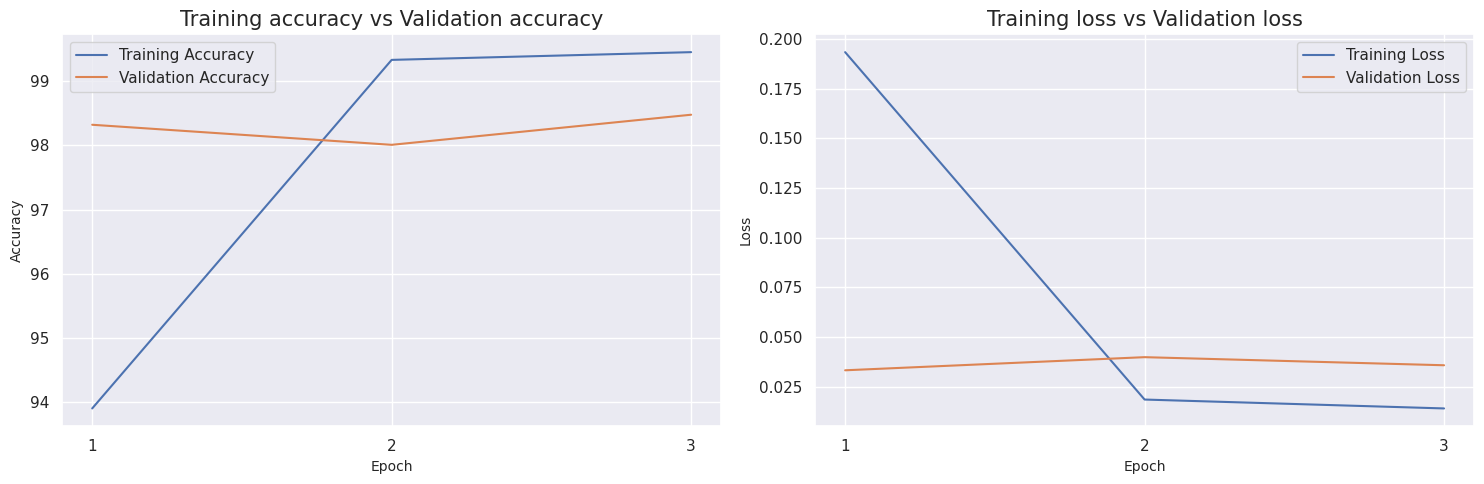

In [85]:
model1 = Model1(input_shape = input_shape, num_classes = num_classes).to(device)
optimizer = optim.Adam(model1.parameters(), lr = 0.001)
results = train_model(model1, 20, optimizer, train_loader, valid_loader, device = device)

In [86]:
class Model2(nn.Module):
  def __init__(self, input_shape, num_classes):
    super(Model2, self).__init__()
    self.network = nn.Sequential(
        nn.Linear(input_shape, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, num_classes)
    )

  def forward(self, x):
    return self.network(x)

Train Acc: 98.434 | Valid Acc: 98.828 | Train Loss: 0.042 | Valid Loss: 0.027:  20%|██        | 4/20 [00:06<00:24,  1.53s/it]

Early stopping at epoch 5


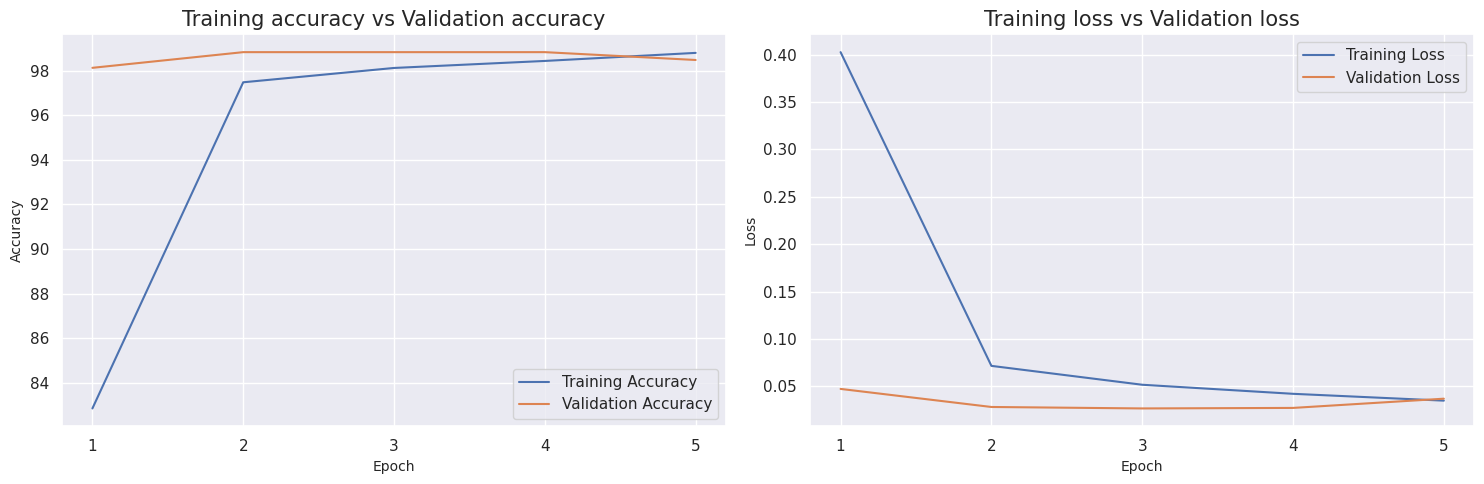

In [87]:
model2 = Model2(input_shape = input_shape, num_classes = num_classes).to(device)
optimizer = optim.Adam(model2.parameters(), lr = 0.001)
results = train_model(model2, 20, optimizer, train_loader, valid_loader, device = device)

In [90]:
class Model3(nn.Module):
  def __init__(self, input_shape, num_classes):
    super(Model3, self).__init__()
    self.network = nn.Sequential(
        nn.Linear(input_shape, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, num_classes)
    )

  def forward(self, x):
    return self.network(x)

Train Acc: 99.050 | Valid Acc: 98.516 | Train Loss: 0.025 | Valid Loss: 0.040:  30%|███       | 6/20 [00:05<00:11,  1.18it/s]

Early stopping at epoch 7


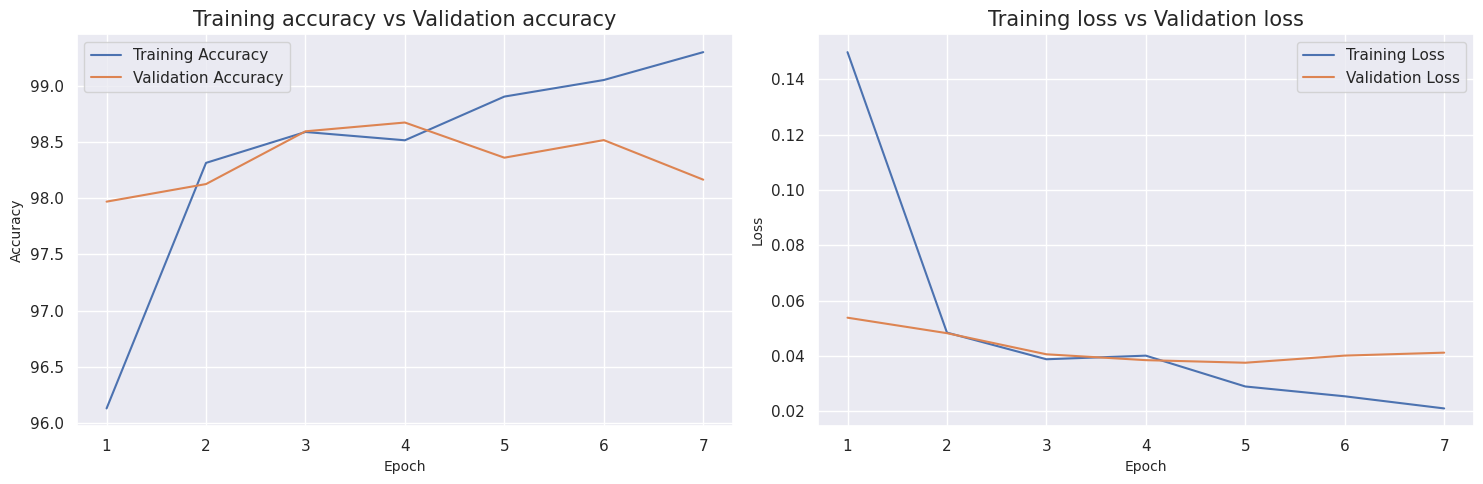

In [91]:
model3 = Model3(input_shape = input_shape, num_classes = num_classes).to(device)
optimizer = optim.Adam(model3.parameters(), lr = 0.001)
results = train_model(model3, 20, optimizer, train_loader, valid_loader, device = device)

In [92]:
class Model4(nn.Module):
  def __init__(self, input_shape, num_classes):
    super(Model4, self).__init__()
    self.network = nn.Sequential(
        nn.Linear(input_shape, 256),

        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(64, num_classes)
    )

  def forward(self, x):
    return self.network(x)

Train Acc: 98.280 | Valid Acc: 98.672 | Train Loss: 0.050 | Valid Loss: 0.033:  40%|████      | 8/20 [00:07<00:11,  1.01it/s]

Early stopping at epoch 9


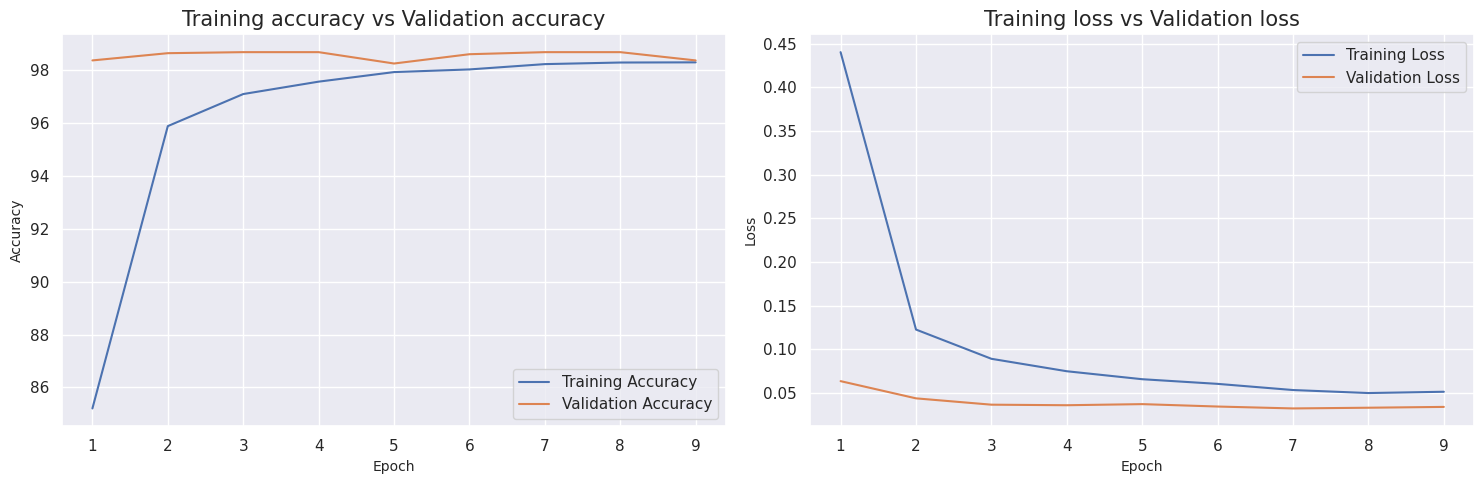

In [93]:
model4 = Model4(input_shape = input_shape, num_classes = num_classes).to(device)
optimizer = optim.Adam(model4.parameters(), lr = 0.001)
results = train_model(model4, 20, optimizer, train_loader, valid_loader, device = device)

In [95]:
model4.eval()
total_loss = 0
total_acc = 0
test_labels, pred_labels = [], []
criterion = nn.CrossEntropyLoss()
with torch.no_grad():
  for x, y in test_loader:
    x, y = x.float().to(device), y.long().to(device)
    preds = model4(x)
    total_loss += criterion(preds, y).item()
    total_acc += (preds.argmax(1) == y).type(torch.float).sum().item()
    test_labels.extend(y.cpu().numpy())
    pred_labels.extend(preds.argmax(1).cpu().numpy())
test_loss = total_loss / len(test_loader)
test_acc = 100 * total_acc / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Test Loss: 0.025
Test Accuracy: 98.985


In [97]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       961
           1       1.00      1.00      1.00       961
           2       1.00      0.96      0.98       961
           3       1.00      1.00      1.00       961

    accuracy                           0.99      3844
   macro avg       0.99      0.99      0.99      3844
weighted avg       0.99      0.99      0.99      3844



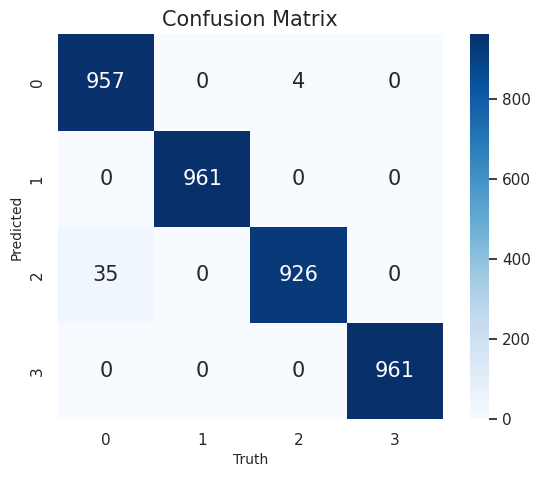

In [98]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(test_labels, pred_labels), annot = True, cbar = True, square = True, annot_kws = {"size": 15}, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix", fontsize = 15)
plt.xlabel("Truth", fontsize = 10)
plt.ylabel("Predicted", fontsize = 10)
plt.show()

In [99]:
X_train

,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Occupation,Smoking,Alcohol_Consumption
4117,18,Female,South Korea,4.7,443.0,4.2,24.1,68,High,6.8,Other,0,0
4226,57,Female,South Korea,1.8,171.8,10.0,22.4,71,Low,12.1,Student,0,0
1026,35,Female,Sweden,3.3,312.1,6.3,19.8,71,Low,5.1,Service,0,0
7229,42,Female,USA,1.3,119.9,7.9,22.2,58,Low,9.4,Student,0,0
878,34,Female,USA,1.1,107.5,6.1,20.0,80,Low,0.3,Office,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7559,32,Male,Spain,1.9,176.6,5.0,25.1,70,Medium,2.7,Office,0,1
3101,45,Male,France,2.7,255.9,6.0,28.0,79,Low,9.5,Service,0,0
895,42,Female,USA,4.8,453.1,7.2,25.4,71,Low,10.8,Office,0,1
2617,35,Female,Spain,0.0,0.0,8.1,27.2,70,Low,10.6,Service,0,0
